# 車牌辨識系統

<img src="https://raw.githubusercontent.com/j82887/Artificial-Intelligence/master/00_Image/19_Implementation%20-%2004_Car_License_Plate.png" align="left" width="200">

# 一、資料前處理

## 01. 處理正樣本影像

In [ ]:
import os, shutil, glob, PIL
from time import sleep
from PIL import Image   

In [ ]:
# 清空資料夾
def emptydir(dirname):
    if os.path.isdir(dirname): # 如果該資料夾是存在為True,反之為False
        shutil.rmtree(dirname) # 依序刪除該資料夾中的檔案
        sleep(2)
    os.mkdir(dirname)

In [ ]:
# src為原影像資料夾, dst為預處理的資料夾
def dirResize(src, dst):
    myfiles = glob.glob(src+'/*.jpg') # 讀取str資料夾中所有副檔名為jpg的檔案名稱
    emptydir(dst)
    for i, f in enumerate(myfiles):
        img = Image.open(f)
        img_new = img.resize((300,225),PIL.Image.ANTIALIAS) # ANTIALIAS為欠取樣，縮小影像為(300,225)
        img_new.save(dst+'/'+'resize'+str('{:0>3d}').format(i+1)+'.bmp') # 將新影像以bmp儲存至dst資料夾

In [ ]:
dirResize('carPlate_sr', 'carPlate')

## 02. 處理負樣本影像

In [ ]:
myfiles = glob.glob("carNegative_sr/*.jpg")
emptydir('carNegative')

for i, f in enumerate(myfiles):
    img = Image.open(f)
    img_new = img.resize((500, 375), PIL.Image.ANTIALIAS)
    img_new = img_new.convert('L')  #轉換為灰階
    img_new.save('carNegative/'+'negGray'+str('{:0>3d}').format(i+1)+'.bmp')

# 二、建立車牌號碼Harr特徵分類器模型

## 01. 安裝與調整套件
1. OpenCV Haar 特徵分類器模型訓練 https://github.com/sauhaardac/haar-training
2. OpenCV 官網 https://opencv.org/releases/ 中，下載```opencv-3.4.9-vc14_vc.exe```
3. 安裝```opencv-3.4.9-vc14_vc.exe```，並打開其資料夾，作以下處理：
    
    A. 將```opencv\build\x64\vc15\bin``` 中的三個檔案，複製到```haar-training\tarining```：
        a. opencv_createsamples.exe
        b. opencv_traincascade.exe
        c. opencv_world349.dll
    B. 刪除```haar-training/tarining```中的兩個檔案：
        a. createsamples.exe
        b. traincascade.exe
3. 加入正/負樣本的影像，刪除```Haar-Training-master\training\negative```與```Haar-Training-master\training\positive```原先檔案

In [ ]:
import cv2
print(cv2.__version__)

## 02. 建立負樣本的影像標註檔

In [ ]:
fp = open('Haar-Training-master/Haar-Training-master/training/negative/bg.txt','w')
files = glob.glob('Haar-Training-master/Haar-Training-master/training/negative/*.bmp')
text = ""
for file in files:
    basename = os.path.basename(file)
    filename = 'negative/'+ basename
    text += filename + "\n"
    print(text)
    
fp.write(text)
fp.close()

## 03. 更正標註檔內正樣本的新舊車牌調整寬高比例

In [ ]:
fp = open('Haar-Training-master/Haar-Training-master/training/positive/info.txt', 'r')
lines = fp.readlines()  #讀取所有文字
rettext = ''

for line in lines:
    data = line.split(' ')
    rettext += data[0] + ' ' + data[1] + ' '

    for i in range(int(n)):
        x = float(data[2+i*4])
        y = float(data[3+i*4])
        w = float(data[4+i*4])
        h = float(data[5+i*4])
        if (w/h) < 3.8:  #如果寬長比小於3.8
            newW = h * 3.8  #寬=高*3.8
            x -= int((newW - w) / 2)  #計算新X位置
            if x<=0:  
                x=0
            w = int(newW)
        rettext = rettext+str(int(x))+' '+data[3+i*4]+' '+str(int(w))+' '+data[5+i*4]

fp.close()

fp = open('Haar-Training-master/Haar-Training-master/training/positive/info.txt', 'w')
fp.write(rettext) 
fp.close()   

In [ ]:
path = 'Haar-Training-master/Haar-Training-master/training/positive/'
fp = open(path + 'info.txt', 'r')
lines = fp.readlines()  #讀取所有文字
count =  len(glob.glob("carPlate/*.bmp")) #圖片數，產生的圖片編號由此繼續

rettext = ''  
for line in lines:
    data = line.split(' ')
    img = Image.open(path + data[0]) 
    
    x = int(data[2])  
    y = int(data[3]) 
    w = int(data[4])  
    h = int(data[5]) 
    
    reduceW = 30  #減少的的寬度
    reduceH = int(reduceW*0.75)  #減少的的高度
    multi = float(300/(300-reduceW))  #原圖與新圖比例
    neww = int(w*multi)  #新圖的寬
    newh = int(h*multi)  #新圖的高
    
    #移除左上角圖
    if (x-reduceW)>5 and (y-reduceH)>5:  #左上角有空間才移除左上角
        count += 1  #編號加1,此數值會做為檔名用
        newimg = img.crop((reduceW, reduceH, 300, 225))  #擷取圖形
        newimg = newimg.resize((300, 225), Image.ANTIALIAS)  #放大圖形
        newimg.save(path + 'rawdata/bmpraw{:0>3d}.bmp'.format(count), 'bmp')  #存檔
        newx = int((x-reduceW)*multi-reduceW*(multi-1)/2)  #新圖X坐標
        newy = int((y-reduceH)*multi-reduceH*(multi-1)/2)  #新圖Y坐標            
        rettext = rettext+'rawdata/bmpraw{:0>3d}.bmp'.format(count)+' '+'1'+' '+str(newx)+' '+str(newy)+' '+str(neww)+' '+str(newh)+'\n'  #記錄新圖資料
    
    #移除右上角圖
    if (x+w)<(300-reduceW-5) and y>(reduceW+5):
        count += 1
        newimg = img.crop((0, reduceH, (300-reduceW), 225))
        newimg = newimg.resize((300, 225), Image.ANTIALIAS)
        newimg.save(path + 'rawdata/bmpraw{:0>3d}.bmp'.format(count), 'bmp')
        newx = int(x*multi)
        newy = int((y-reduceH)*multi)
        rettext = rettext+'rawdata/bmpraw{:0>3d}.bmp'.format(count)+' '+'1'+' '+str(newx)+' '+str(newy)+' '+str(neww)+' '+str(newh)+'\n'
    
    #移除左下角圖
    if (x-reduceW)>5 and (y+h)<(225-reduceH-5):
        count += 1
        newimg = img.crop((reduceW, 0, 300, 225-reduceH))
        newimg = newimg.resize((300, 225), Image.ANTIALIAS)
        newimg.save(path + 'rawdata/bmpraw{:0>3d}.bmp'.format(count), 'bmp')
        newx = int((x-reduceW)*multi)
        newy = int(y*multi)
        rettext = rettext+'rawdata/bmpraw{:0>3d}.bmp'.format(count)+' '+'1'+' '+str(newx)+' '+str(newy)+' '+str(neww)+' '+str(newh)+'\n'
    
    #移除右下角圖
    if (x+w)<(300-reduceW-5) and (y+h)<(225-reduceH-5):
        count += 1
        newimg = img.crop((0, 0, (300-reduceW), 225-reduceH))
        newimg = newimg.resize((300, 225), Image.ANTIALIAS)
        newimg.save(path + 'rawdata/bmpraw{:0>3d}.bmp'.format(count), 'bmp')
        newx = int(x*multi)
        newy = int(y*multi)
        rettext = rettext+'rawdata/bmpraw{:0>3d}.bmp'.format(count)+' '+'1'+' '+str(newx)+' '+str(newy)+' '+str(neww)+' '+str(newh)+'\n'

fp.close()
    
fpmake = open(path + 'Info.txt', 'a')  #以新增資料方式開啟檔案
fpmake.write(rettext)  #寫入檔案
fpmake.close()

## 04. 使用Haar特徵分類器偵測車牌

[[ 64  83 159  42]]


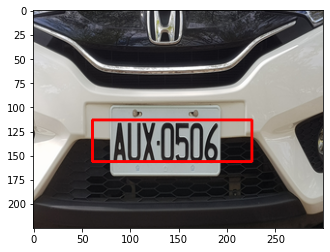

In [138]:
import cv2
import matplotlib.pyplot as plt
img_path = 'carPlate/resize003.bmp'

img = cv2.imread(img_path)
detector = cv2.CascadeClassifier("License_Plate_Haar_cascade.xml")
signs = detector.detectMultiScale(img, minSize = (76, 20), scaleFactor = 1.1, minNeighbors=10)

if len(signs) > 0:
    for (sx, sy, sw, sh) in signs:
        cv2.rectangle(img, (sx, sy), (sx+sw, sy+sh), (0, 0, 255), 2)
        print(signs)
else:
    print('沒有辨識到車牌!')

''' 
=============== 
OpenCV 讀取影像 
===============
cv2.imshow('Frame', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

plt.imshow(cv2.cvtColor(img_pl, cv2.COLOR_BGR2RGB))
plt.show()

影像維度： (42, 159)


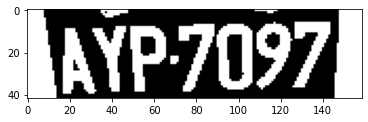

In [139]:
img = cv2.imread(img_path)
crop_img = img[sy:sy+sh, sx:sx+sw]

gray_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
_, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV) 
print('影像維度：',binary_img.shape)

plt.imshow(binary_img, cmap='gray')
plt.show()

(68, 22, 4, 4)
(17, 9, 16, 31)
(49, 8, 17, 31)
(31, 8, 16, 31)
(90, 7, 17, 31)
(72, 7, 17, 32)
(126, 6, 18, 31)
(109, 6, 17, 32)
(146, 0, 13, 42)
(108, 0, 11, 2)
(35, 0, 13, 4)
(0, 0, 14, 42)


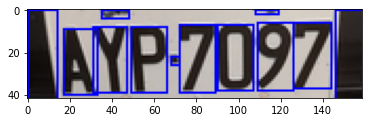

In [140]:
img = cv2.imread(img_path)
crop_img = img[sy:sy+sh, sx:sx+sw]

contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    (x, y, w, h) = cv2.boundingRect(contours[i])
    print((x, y, w, h))
    cv2.rectangle(crop_img, (x, y), (x+w, y+h), (0, 0, 255), 1)

plt.imshow(crop_img)
plt.show()

(17, 9, 16, 31)
(49, 8, 17, 31)
(31, 8, 16, 31)
(90, 7, 17, 31)
(72, 7, 17, 32)
(126, 6, 18, 31)
(109, 6, 17, 32)


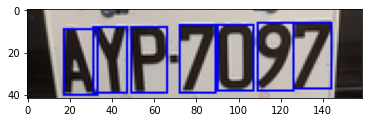

In [141]:
img = cv2.imread(img_path)
crop_img = img[sy:sy+sh, sx:sx+sw]

contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    (x, y, w, h) = cv2.boundingRect(contours[i])
    if w>5 and 39>h>29:
        print((x, y, w, h))
        cv2.rectangle(crop_img, (x, y), (x+w, y+h), (0, 0, 255), 1)
        
plt.imshow(crop_img)
plt.show()